In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
vistas_raw = pd.read_csv('../data/datos_navent_fiuba/fiuba_3_vistas.csv')
postulaciones_raw = pd.read_csv('../data/datos_navent_fiuba/fiuba_4_postulaciones.csv')
avisos_raw = pd.read_csv('../data/datos_navent_fiuba/fiuba_6_avisos_detalle.csv')
generos_raw = pd.read_csv('../data/datos_navent_fiuba/fiuba_2_postulantes_genero_y_edad.csv')
educacion_raw = pd.read_csv('../data/datos_navent_fiuba/fiuba_1_postulantes_educacion.csv')

## Preguntas
* **Avisos con más postulaciones**
* **Relación vistas/postulaciones para un mismo aviso**
* **Distribución horaria de postulaciones**
* **Distribución postulaciones por día**
* **Distribución postulaciones por género**
* **Correlación usuario-postulaciones** - analizar si un mismo usuario se postula a avisos del mismo área o no

In [3]:
print(postulaciones_raw.info())
print('---------------------------------')
postulaciones_raw.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3401623 entries, 0 to 3401622
Data columns (total 3 columns):
idaviso             int64
idpostulante        object
fechapostulacion    object
dtypes: int64(1), object(2)
memory usage: 77.9+ MB
None
---------------------------------


,idaviso,idpostulante,fechapostulacion
0,1112257047,NM5M,2018-01-15 16:22:34


**Limpieza y transformaciones**

In [4]:
postulaciones_raw.isna().any()

idaviso             False
idpostulante        False
fechapostulacion    False
dtype: bool

In [5]:
postulaciones = postulaciones_raw.rename(columns={'fechapostulacion':'fecha'})

In [6]:
postulaciones['fecha'] = pd.to_datetime(postulaciones.fecha)

In [7]:
postulaciones.dtypes

idaviso                  int64
idpostulante            object
fecha           datetime64[ns]
dtype: object

**Análisis**

In [8]:
# TOP avisos con más postulaciones
data = pd.merge(postulaciones,avisos_raw[['idaviso','titulo','nombre_area']], on='idaviso')
print(data.isna().any())
data.head(1)

idaviso         False
idpostulante    False
fecha           False
titulo          False
nombre_area     False
dtype: bool


,idaviso,idpostulante,fecha,titulo,nombre_area
0,1112257047,NM5M,2018-01-15 16:22:34,REPRESENTANTES DE ATENCIÓN AL CLIENTE/ RETENCIÓN,Atención al Cliente


In [9]:
top_post = data.idaviso.value_counts().reset_index().rename(columns={'idaviso':'count','index':'idaviso'})

In [10]:
data.idaviso.value_counts().head(3)

1112033906    9932
1112334791    9787
1112204682    9244
Name: idaviso, dtype: int64

In [11]:
top_post.head(3)

,idaviso,count
0,1112033906,9932
1,1112334791,9787
2,1112204682,9244


In [12]:
avisos_raw[avisos_raw.idaviso == 1112334791]

,idaviso,idpais,titulo,descripcion,nombre_zona,ciudad,mapacalle,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa
13003,1112334791,1,Cajero/a - Part Time,<p>Te estamos buscando para formar parte de un...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Comercial,Farmacity


In [13]:
seleccion = avisos_raw.idaviso.isin(top_post.idaviso)
top_post['titulo'] = avisos_raw.loc[seleccion,'titulo'].values
top_post['area'] = avisos_raw.loc[seleccion,'nombre_area'].values
top_post.head(3)

,idaviso,count,titulo,area
0,1112033906,9932,VENDEDOR/A PROVINCIA DE SANTA FE,Comercial
1,1112334791,9787,CHOFER DE CAMIONETA BAHIA BLANCA - PUNTA ALTA,Transporte
2,1112204682,9244,Vendedor Viajante TUCUMAN/SANTIAGO DEL ESTERO,Ventas


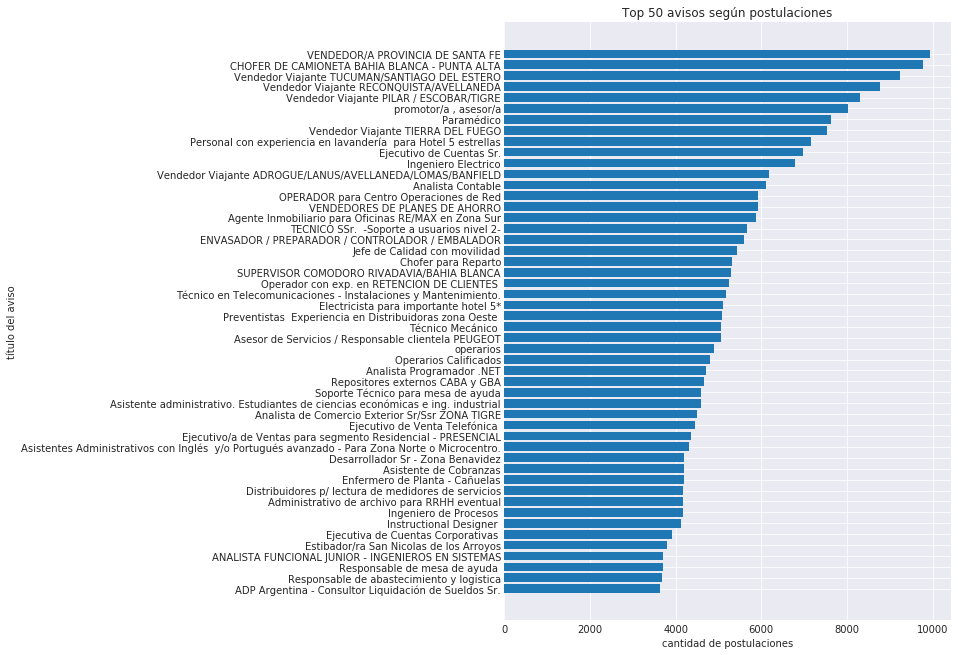

In [14]:
plot_data = top_post[['titulo','count']].head(50).iloc[::-1]
plt.figure(figsize=(8,11))
plt.title('Top 50 avisos según postulaciones')
plt.barh(plot_data['titulo'], plot_data['count'])
plt.xlabel('cantidad de postulaciones')
plt.ylabel('título del aviso')
plt.show()

### **Postulaciones segun nivel eductivo**
Analicemos como sonlas postulaciones según enl nivel educativo de los postulantes

In [15]:
data = postulaciones.merge(avisos_raw[['idaviso','titulo','nombre_area']], on='idaviso')\
                    .merge(educacion_raw, on='idpostulante')\
                    .merge(generos_raw,on='idpostulante')\
                    .rename(columns={'nombre_area':'area','nombre':'nivel_educ'})

In [16]:
print(data.info())
print(data.isna().any())
data.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5012172 entries, 0 to 5012171
Data columns (total 9 columns):
idaviso            int64
idpostulante       object
fecha              datetime64[ns]
titulo             object
area               object
nivel_educ         object
estado             object
fechanacimiento    object
sexo               object
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 382.4+ MB
None
idaviso            False
idpostulante       False
fecha              False
titulo             False
area               False
nivel_educ         False
estado             False
fechanacimiento     True
sexo               False
dtype: bool


,idaviso,idpostulante,fecha,titulo,area,nivel_educ,estado,fechanacimiento,sexo
0,1112257047,NM5M,2018-01-15 16:22:34,REPRESENTANTES DE ATENCIÓN AL CLIENTE/ RETENCIÓN,Atención al Cliente,Secundario,Graduado,1970-12-03,FEM


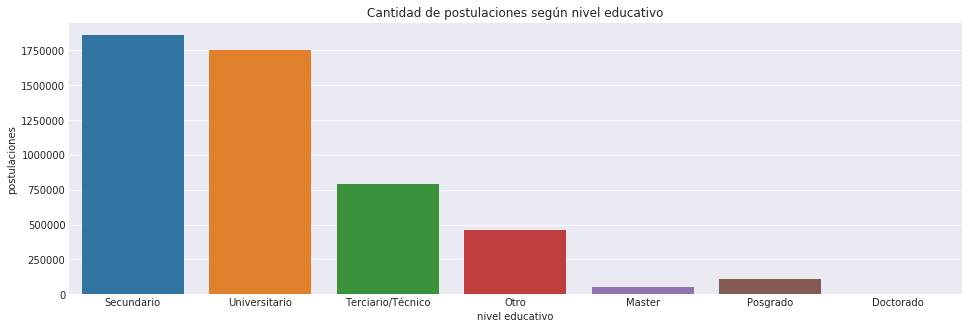

In [17]:
plt.figure(figsize=(16,5))
plt.title('Cantidad de postulaciones según nivel educativo')
sns.countplot(x=data['nivel_educ'],data=data)
plt.xlabel('nivel educativo')
plt.ylabel('postulaciones')
plt.show()

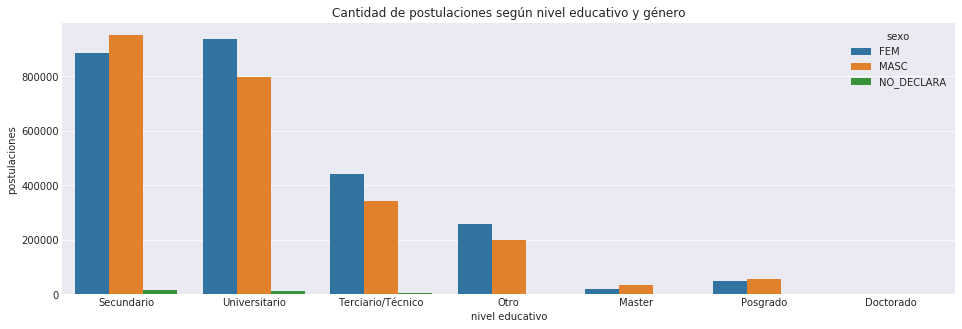

In [18]:
plt.figure(figsize=(16,5))
plt.title('Cantidad de postulaciones según nivel educativo y género')
sns.countplot(x=data['nivel_educ'],data=data, hue=data['sexo'])
plt.xlabel('nivel educativo')
plt.ylabel('postulaciones')
plt.show()

In [19]:
data_to_pivot = data
data_to_pivot['count'] = 1
data_pivoted = data_to_pivot[['nivel_educ','sexo','count']].groupby(['sexo','nivel_educ']).sum().pivot_table(values='count',index='sexo',columns='nivel_educ')
data_pivoted

nivel_educ,Doctorado,Master,Otro,Posgrado,Secundario,Terciario/Técnico,Universitario
sexo,,,,,,,
FEM,2014,20545,259573,49297,887189,440469,936469
MASC,1228,32445,199532,57044,949808,341201,797700
NO_DECLARA,15,195,1511,401,17454,5125,12957


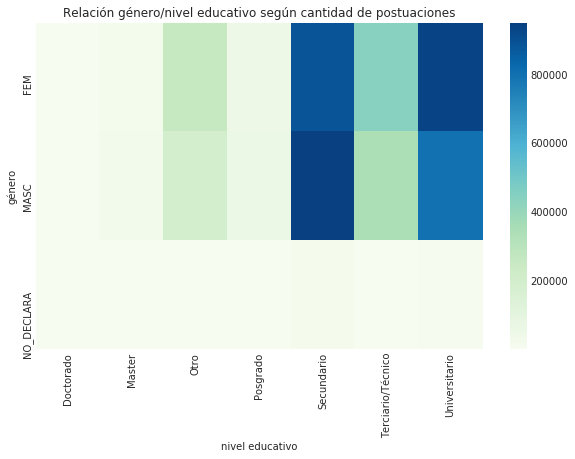

In [20]:
plt.figure(figsize=(10,6))
plt.title('Relación género/nivel educativo según cantidad de postuaciones')
sns.heatmap(data_pivoted, cmap='GnBu')
plt.xlabel('nivel educativo')
plt.ylabel('género')
plt.show()

### **Top áreas con más postulaciones**

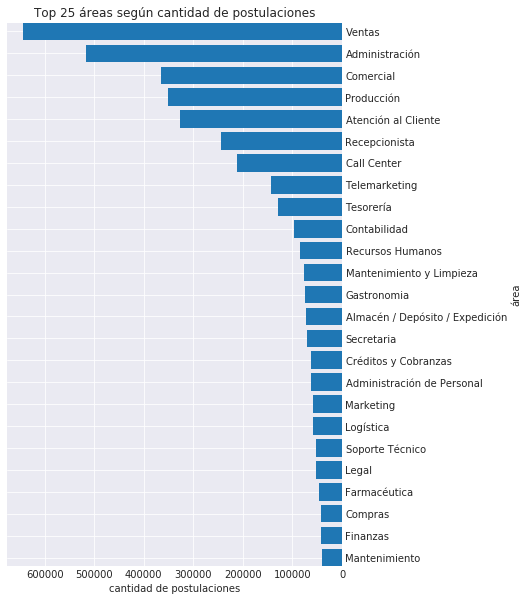

In [34]:
plot_data = data.area.value_counts().head(25).iloc[::-1]
plt.figure(figsize=(6,10))
plt.title('Top 25 áreas según cantidad de postulaciones')
plt.barh(plot_data.index,plot_data.values)
plt.xlabel('cantidad de postulaciones')
plt.ylabel('área')
plt.autoscale(tight=True, axis='y')
plt.gca().invert_xaxis()
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")
plt.show()

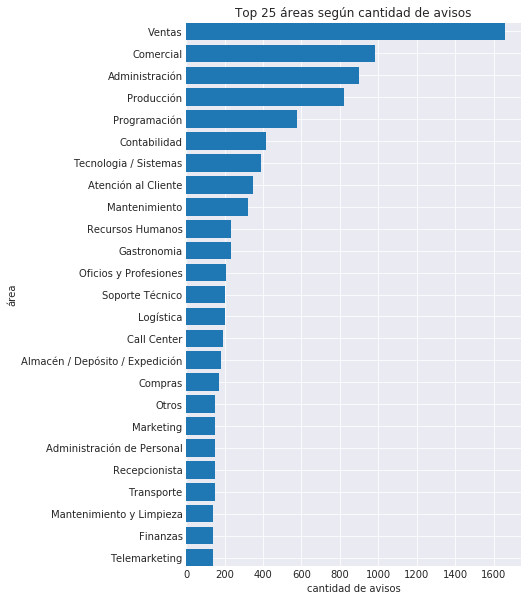

In [35]:
plot_data = avisos_raw.nombre_area.value_counts().head(25).iloc[::-1]
plt.figure(figsize=(6,10))
plt.title('Top 25 áreas según cantidad de avisos')
plt.barh(plot_data.index,plot_data.values)
plt.xlabel('cantidad de avisos')
plt.ylabel('área')
plt.autoscale(tight=True, axis='y')
#plt.gca().yaxis.tick_right()
#plt.gca().yaxis.set_label_position("right")
plt.show()

## **Relación vistas/postulaciones**

In [18]:
vistas = vistas_raw.idAviso.value_counts().reset_index().rename(columns={'idAviso':'vistas','index':'idaviso'})
postulaciones = postulaciones_raw.idaviso.value_counts().reset_index().rename(columns={'idaviso':'postulaciones','index':'idaviso'})

In [19]:
vistas.head(1)

,idaviso,vistas
0,1112363488,4169


In [20]:
postulaciones.head(1)

,idaviso,postulaciones
0,1112033906,9932


In [39]:
vistas_y_post = pd.merge(vistas, postulaciones, on='idaviso')
vistas_y_post.head(1)

,idaviso,vistas,postulaciones
0,1112363488,4169,1244


In [47]:
# Aproximación lineal por cuadrados mínimos
x = vistas_y_post['vistas']
y = vistas_y_post['postulaciones']
fit = np.polyfit(x, y, deg=1)
least_squares_aprox = fit[0] * x + fit[1]

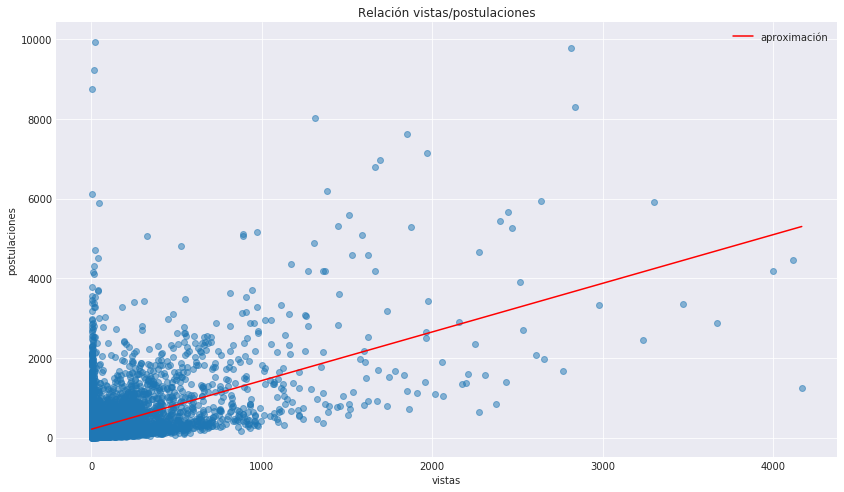

In [49]:
plt.figure(figsize=(14,8))
plt.title('Relación vistas/postulaciones')
plt.scatter(x=vistas_y_post.vistas,y=vistas_y_post.postulaciones, alpha=.5)
plt.plot(x, least_squares_aprox, color='red', label='aproximación')
plt.legend(['aproximación'])
plt.xlabel('vistas')
plt.ylabel('postulaciones')
plt.show()

In [52]:
vistas_y_post_filtered = vistas_y_post[vistas_y_post['vistas']<2000]
# Aproximación por cuadrados mínimos
x = vistas_y_post_filtered['vistas']
y = vistas_y_post_filtered['postulaciones']
fit = np.polyfit(x, y, deg=1)
least_squares_aprox = fit[0] * x + fit[1]

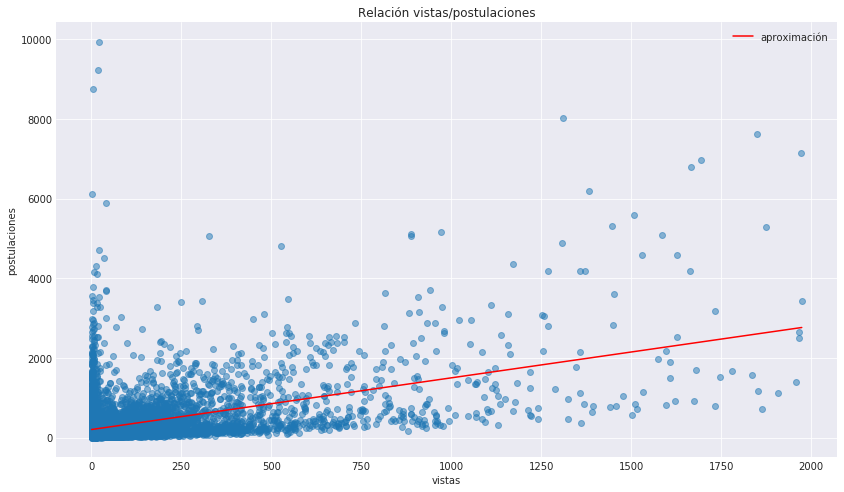

In [53]:
plt.figure(figsize=(14,8))
plt.title('Relación vistas/postulaciones')
plt.scatter(x=vistas_y_post_filtered.vistas,y=vistas_y_post_filtered.postulaciones, alpha=.5)
plt.plot(x, least_squares_aprox, color='red', label='aproximación')
plt.legend(['aproximación'])
plt.xlabel('vistas')
plt.ylabel('postulaciones')
plt.show()